In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from transformers import TrainingArguments, set_seed

from data import SharedTaskData
from models import MultitaskModel
from train_mtl import Tokenize, compute_metrics, prepare_data
from trainers import MultitaskTrainer, NLPDataCollator, TASK_NAMES

/data/volume_2/venvs/vargmining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set variables.
checkpoint: str = "hftrainer_am_mtl_../SimCSE/result/novelty-sup-simcse-sup-roberta-large-mnli/_10_1e-05_0/checkpoint-846"
use_model: str = "roberta-large-mnli"
seed: int = 0
tensorflows: bool = False

In [3]:
# Load dataset.
set_seed(seed)
tokenize = Tokenize(use_model, tensorflows, "concatenation", predict_only=False)
torch.backends.cudnn.deterministic = True

train_data = SharedTaskData("TaskA_train.csv")
dev_data = SharedTaskData("TaskA_test.csv")

tokenized_train_dataset_novelty, tokenized_dev_dataset_novelty = prepare_data(
    use_model,
    train_data,
    dev_data,
    "novelty",
    tokenize.tokenize_function_nov
)
tokenized_train_dataset_validity, tokenized_dev_dataset_validity = prepare_data(
    use_model,
    train_data,
    dev_data,
    "validity",
    tokenize.tokenize_function_val
)

if "ArgumentRelation" in use_model:
    kwargs = {'pad_token_id': 1}
else:
    kwargs = {}

# Load model.
multitask_model = MultitaskModel.create(
    model_name=use_model,
    model_type_dict={
        "novelty": transformers.AutoModelForSequenceClassification,
        "validity": transformers.AutoModelForSequenceClassification,
    },
    model_config_dict={
        "novelty": transformers.AutoConfig.from_pretrained(use_model, num_labels=2, **kwargs),
        "validity": transformers.AutoConfig.from_pretrained(use_model, num_labels=2, **kwargs),
    },
    tensorflows=tensorflows
)

multitask_model.load_trainer_checkpoint(checkpoint)

# Load trainer/evaluator.
val_dataset = {
    "novelty": tokenized_dev_dataset_novelty,
    "validity": tokenized_dev_dataset_validity,
}

train_dataset = {
    "novelty": tokenized_train_dataset_novelty,
    "validity": tokenized_train_dataset_validity,
}

training_args = TrainingArguments(
    f"hftrainer_am_mtl_{use_model}_{seed}",
    label_names=['labels']
)

trainer = MultitaskTrainer(
    model=multitask_model,
    data_collator=NLPDataCollator(tokenizer=tokenize.tokenizer),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenize.tokenizer,
    compute_metrics=compute_metrics,
    args=training_args,
)

Parameter 'function'=<function map_label at 0x7fdb902df9d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


[None]
[None]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22ba/s]
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large-mnli and are newly initialized because the shapes did not match:
- classifier.o

In [5]:
# Get predictions on validation set.
outputs = trainer.predict(val_dataset)
# for task in TASK_NAMES:
    # print(f"{task}: Amount of mistakes: {torch.sum(outputs[task]['predictions'] != torch.tensor(outputs[task]['labels']))}")

***** Running Prediction *****
  Num examples = 520
  Batch size = 16


Predicting novelty


/data/volume_2/venvs/vargmining/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Prediction *****
  Num examples = 520
  Batch size = 16


Predicting validity


/data/volume_2/venvs/vargmining/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 1 0 0 1 

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
print(outputs.keys())
print()
print(np.argmax(outputs['novelty'].predictions, axis=1))

model_output_val = np.argmax(outputs['validity'].predictions, axis=1)
model_output_nov = np.argmax(outputs['novelty'].predictions, axis=1)
print("VALIDITY")
val_true = dev_data.df.Validity.apply(lambda x: 1 if x == 1 else 0)
print(classification_report(model_output_val, val_true, digits=3))
print(confusion_matrix(model_output_val, val_true).T)

print("NOVELTY")
nov_true = dev_data.df.Novelty.apply(lambda x: 1 if x == 1 else 0)
print(classification_report(model_output_nov, nov_true, digits=3))
print(confusion_matrix(model_output_nov, nov_true).T)

dict_keys(['novelty', 'validity'])

[0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0

In [39]:
import json
with open("predictions/dump_prompt_5_eval=True_results.json") as f:
    d = json.load(f)

pred_val_gpt = [1 if x['pred_val'] == 'valid' else 0 for x in d ]
pred_nov_gpt = [1 if x['pred_nov'] == 'novel' else 0 for x in d ]
print("VALIDITY")
print(classification_report(pred_val_gpt, val_true, digits=3))
print(confusion_matrix(pred_val_gpt, val_true).T)
print("NOVELTY")
print(classification_report(pred_nov_gpt, nov_true, digits=3))
print(confusion_matrix(pred_nov_gpt, val_true).T)

VALIDITY
              precision    recall  f1-score   support

           0      0.583     0.670     0.623       179
           1      0.812     0.748     0.779       341

    accuracy                          0.721       520
   macro avg      0.697     0.709     0.701       520
weighted avg      0.733     0.721     0.725       520

[[120  86]
 [ 59 255]]
NOVELTY
              precision    recall  f1-score   support

           0      0.816     0.570     0.671       421
           1      0.199     0.455     0.277        99

    accuracy                          0.548       520
   macro avg      0.508     0.512     0.474       520
weighted avg      0.699     0.548     0.596       520

[[157  49]
 [264  50]]


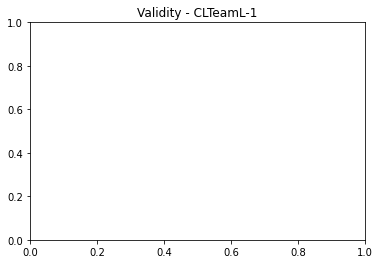

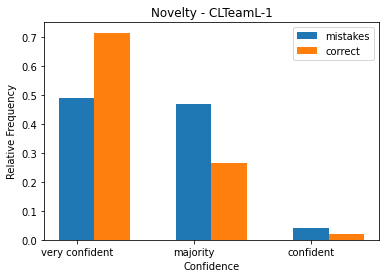

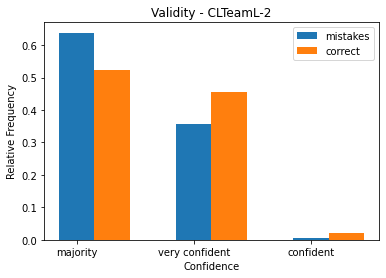

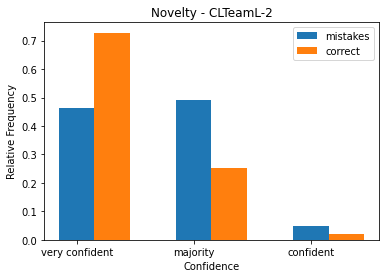

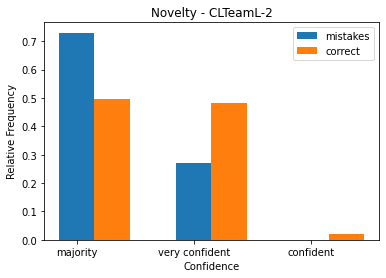

In [85]:
# Get (mis-)classification of predictions based on confidence of annotation.
%matplotlib inline

# Retrieve confidences of the mistakes and correct classifications.
def plot_confidences(predictions, labels, task, approach):
    mistakes_idxs = (np.array(predictions) != np.array(labels)).nonzero()
    confs_mistakes = dev_data.df.iloc[mistakes_idxs][f"{task.capitalize()}-Confidence"]
    correct_idxs = (np.array(predictions) == np.array(labels)).nonzero()
    confs_correct = dev_data.df.iloc[correct_idxs][f"{task.capitalize()}-Confidence"]

    # Normalize over the total count of mistakes and corrects respectively.
    confs_mistakes = {k: v / confs_mistakes.count() for k, v in confs_mistakes.value_counts().to_dict().items()}
    confs_correct = {k: v / confs_correct.count() for k, v in confs_correct.value_counts().to_dict().items()}

    # Uncomment if background is black so text of plot is white.
    params = {"ytick.color" : "black",
              "xtick.color" : "black",
              "axes.labelcolor" : "black",
              "figure.facecolor": "w",
              "axes.edgecolor" : "black"}
    plt.rcParams.update(params)
    plt.title(f"{task.capitalize()} - {approach}", color='black')

    np.random.seed(0)
    plt.figure()
    plt.xticks(range(len(list(confs_correct.keys()))), list(confs_correct.keys()))
    plt.xlabel('Confidence')
    plt.ylabel('Relative Frequency')
    plt.title(f"{task.capitalize()} - {approach}", color='black')

    width = 0.3
    plt.bar(range(len(confs_correct.keys())), [confs_mistakes.get(k, 0) for k in confs_correct.keys()], label="mistakes", width=width)
    plt.bar(np.arange(len(confs_correct)) + width, confs_correct.values(), label="correct", width=width)
    plt.legend()
    plt.savefig(f"confidence_{approach}_{task}.png")


plot_confidences(pred_val_gpt, val_true, "validity", "CLTeamL-1")
plot_confidences(pred_nov_gpt, nov_true, "novelty", "CLTeamL-1")

plot_confidences(model_output_val, val_true, "validity", "CLTeamL-2")
plot_confidences(model_output_nov, nov_true, "novelty", "CLTeamL-2")


In [87]:
# Get distribution of mistakes over combined labels.

def get_mistake_dist(predictions, labels, task, approach):
    idxs = (np.array(predictions) != np.array(labels)).nonzero()
    val_mistakes = dev_data.df.iloc[idxs]["Validity"]
    nov_mistakes = dev_data.df.iloc[idxs]["Novelty"]

    counts = defaultdict(int)
    for val_mistake, nov_mistake in zip(val_mistakes, nov_mistakes):
        if val_mistake == -1 and nov_mistake == -1:
            counts["non-valid;non-novel"] += 1
        elif val_mistake == 1 and nov_mistake == -1:
            counts["valid;non-novel"] += 1
        elif val_mistake == -1 and nov_mistake == 1:
            counts["non-valid;novel"] += 1
        elif val_mistake == 1 and nov_mistake == 1:
            counts["valid;novel"] += 1

    counts = {k: v / len(val_mistakes) for k, v in counts.items()}
    print(approach)
    print(counts)


get_mistake_dist(pred_val_gpt, val_true, "validity", "CLTeamL-1")
get_mistake_dist(pred_nov_gpt, nov_true, "novelty", "CLTeamL-1")

get_mistake_dist(model_output_val, val_true, "validity", "CLTeamL-2")
get_mistake_dist(model_output_nov, nov_true, "novelty", "CLTeamL-2")

CLTeamL-1
{'non-valid;non-novel': 0.31724137931034485, 'non-valid;novel': 0.27586206896551724, 'valid;non-novel': 0.2206896551724138, 'valid;novel': 0.18620689655172415}
CLTeamL-1
{'valid;novel': 0.4553191489361702, 'non-valid;non-novel': 0.1148936170212766, 'valid;non-novel': 0.1148936170212766, 'non-valid;novel': 0.3148936170212766}
CLTeamL-2
{'non-valid;novel': 0.4563758389261745, 'valid;novel': 0.11409395973154363, 'non-valid;non-novel': 0.4228187919463087, 'valid;non-novel': 0.006711409395973154}
CLTeamL-2
{'valid;novel': 0.45977011494252873, 'non-valid;non-novel': 0.09770114942528736, 'valid;non-novel': 0.06896551724137931, 'non-valid;novel': 0.3735632183908046}


In [94]:
# Get percentage of mistakes per topic.
def get_pct_mistakes(predictions, labels, task, approach):
    idxs = (np.array(predictions) != np.array(labels)).nonzero()
    topics_mistakes = dev_data.df.iloc[idxs]["topic"]

    topic_results = topics_mistakes.value_counts() / dev_data.df["topic"].value_counts()
    print(f"== {approach} - {task} ==")
    print(topic_results)

print("Score is percentage of mistakes per topic.")
get_pct_mistakes(pred_val_gpt, val_true, 'validity', "CLTeamL-1")
get_pct_mistakes(pred_nov_gpt, nov_true, 'novelty', "CLTeamL-1")

get_pct_mistakes(model_output_val, val_true, 'validity', "CLTeamL-2")
get_pct_mistakes(model_output_nov, nov_true, 'novelty', "CLTeamL-2")

Score is percentage of mistakes per topic.
== CLTeamL-1 - validity ==
Veal                                            0.216216
Vegetarianism                                   0.080000
Video games                                          NaN
Video surveillance                              0.250000
War on Drugs                                    0.264151
Warrantless wiretapping in the United States    0.148148
Was the War in Iraq worth it?                   0.448276
Water privatization                             0.244898
Wave power                                      0.125000
Wind energy                                     0.120000
Withdrawing from Iraq                           0.380597
Year-round school                               0.396552
Yucca Mountain nuclear waste repository         0.375000
Zero tolerance law                              0.210526
Zoos                                                 NaN
Name: topic, dtype: float64
== CLTeamL-1 - novelty ==
Veal                 